In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import scipy.signal as signal
import sklearn
import os
from sklearn.metrics import normalized_mutual_info_score, pairwise_distances
from scipy.stats import spearmanr

In [2]:
print('numpy, v.', np.__version__)
print('sklearn, v.', sklearn.__version__)

numpy, v. 1.19.0
sklearn, v. 0.23.1


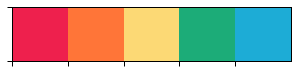

In [3]:
sns.set_context('paper')

pal = sns.crayon_palette(['Red', 'Orange', 'Goldenrod', 'Green', 'Cerulean'])
sns.set_palette(pal)
sns.palplot(pal)

In [4]:
pd.options.mode.chained_assignment = None

def consecutive(data, stepsize=0.000501):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def comb_band_stop(notch, filtered, Q, fs):
    max_harmonic = int(nyquist/notch)
    min_harmonic = 1
    for i in np.arange(1, max_harmonic):
        #print(notch * i)
        f0 = notch * i
        w0 = f0/nyquist
        b,a = signal.iirnotch(w0, Q)
        filtered = signal.filtfilt(b, a, filtered)
    j = 1
    while (notch / j) > 1:
        #print(notch * i)
        f0 = notch / i
        w0 = f0/nyquist
        b,a = signal.iirnotch(w0, Q)
        filtered = signal.filtfilt(b, a, filtered)
        j += 1
    return filtered

# Comparing frequency spectra across scans across denoising approaches
## ECG collected during multiband, single-echo EPI sequence

In [5]:
data_fname = '../data/raw/mbse-raw.csv'
timeseries = pd.read_csv(data_fname, header=0, index_col=0)
basename = data_fname.split('/')[-1][:-4]

slices = 60
tr = 0.8
mb = 6
cutoff = 120

fs = 2000.

nyquist = fs/2
Q = 100

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
fft_eda_nomri = signal.decimate(np.fft.fft(timeseries[timeseries['Trigger'] != 5]['EDA'][:1000000]), 10)
freq_eda_nomri = signal.decimate(np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['EDA'][:1000000].shape[-1], 
                                                d=0.0005), 10)

limit = np.where(freq_eda_nomri >= 60)[0][0]

In [7]:
scans = timeseries['scan'].unique()
scans = [x for x in scans if not np.isnan(x)]
print(scans)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


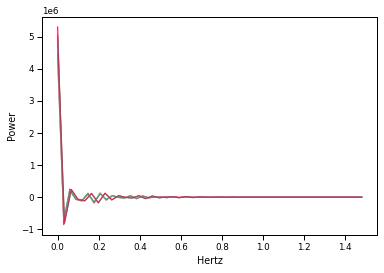

In [8]:
fft_eda = {}
freq = {}
eda = {}
for scan in scans:
    eda[scan] = timeseries[timeseries['scan'] == scan]['EDA']
    fft_eda[scan] = signal.decimate(np.fft.fft(eda[scan]), 10)
    freq[scan] = signal.decimate(np.fft.fftfreq(eda[scan].shape[-1], d=0.0005), 10)
    limit = np.where(freq[scan].real >= 1.5)[0][0]
    g = sns.lineplot(freq[scan][:limit], fft_eda[scan].real[:limit])
    g.set_xlabel('Hertz')
    g.set_ylabel('Power')

In [9]:
np.where(freq[scan].real >= 1.5)[0][0]

46

In [10]:
steps_in_denoising = ['raw', 'BIOPAC', 'MB-BIOPAC', 'Bottenhorn']

In [11]:
index = pd.MultiIndex.from_product([scans, steps_in_denoising], names=['scan', 'step'])

In [12]:
#msc = {}
dist = pd.DataFrame(index=index, columns=index, dtype=float)
for scan1 in scans:
    fft1 = fft_eda[scan1].real
    corr = np.corrcoef(abs(fft1[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
    dist.at[(scan1, 'raw'), 'noMR'] = corr
    
    notch = slices / tr
    filtered = comb_band_stop(notch, eda[scan1], Q, fs)
    fft_bpfilt1 = signal.decimate(np.fft.fft(filtered),10)
    corr = np.corrcoef(abs(fft_bpfilt1[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
    dist.at[(scan1, 'BIOPAC'), 'noMR'] = corr
    
    corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'BIOPAC')] = corr
    dist.at[(scan1, 'BIOPAC'), (scan1, 'raw')] = corr
    
    notch = slices / mb / tr
    filtered = comb_band_stop(notch, eda[scan1], Q, fs)
    fft_bpmbfilt1 = signal.decimate(np.fft.fft(filtered), 10)
    corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
    dist.at[(scan1, 'MB-BIOPAC'), 'noMR'] = corr
    corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'MB-BIOPAC')] = corr
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'raw')] = corr
    corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
    dist.at[(scan1, 'BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'BIOPAC')] = corr
    
    notches = {'slices': slices / mb / tr, 
               'tr': 1 / tr}
    filtered1 = eda[scan1]
    for notch in notches:
        filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)
    
    fft_bottfilt1 = signal.decimate(np.fft.fft(filtered1), 10)
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
    dist.at[(scan1, 'Bottenhorn'), 'noMR'] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
    dist.at[(scan1, 'Bottenhorn'), 'noMR'] = corr
    
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft1[:14000]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'raw')] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
    dist.at[(scan1, 'BIOPAC'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'BIOPAC')] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'MB-BIOPAC')] = corr

    for scan2 in scans:
        fft2 = fft_eda[scan2].real
        corr =  np.corrcoef(abs(fft1[:14000]), abs(fft2[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'raw')] = corr
        dist.at[(scan1, 'raw'), (scan2, 'raw')] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
        dist.at[(scan2, 'raw'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_bottfilt1[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'Bottenhorn')] = corr

        notch = slices / tr
        filtered = comb_band_stop(notch, eda[scan2], Q, fs)
        fft_bpfilt2 = signal.decimate(np.fft.fft(filtered),10)
        corr = np.corrcoef(abs(fft_bpfilt2[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bpfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'Bottenhorn')] = corr
        #corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        #dist.at[(scan2, 'BIOPAC'), (scan1, 'raw')] = corr

        notch = slices / mb / tr
        filtered = comb_band_stop(notch, eda[scan2], Q, fs)
        fft_bpmbfilt2 = signal.decimate(np.fft.fft(filtered), 10)
        corr = np.corrcoef(abs(fft_bpmbfilt2[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_bpmbfilt2[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpmbfilt2[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'Bottenhorn')] = corr
        
        filtered1 = eda[scan2]
        for notch in notches:
            filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)

        fft_bottfilt2 = signal.decimate(np.fft.fft(filtered1),10)
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bottfilt2[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'Bottenhorn')] = corr

        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft2[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpmbfilt2[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan2, 'Bottenhorn')] = corr
        
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan1, 'raw'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan1, 'BIOPAC'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
        dist.at[(scan1, 'MB-BIOPAC'), (scan2, 'Bottenhorn')] = corr

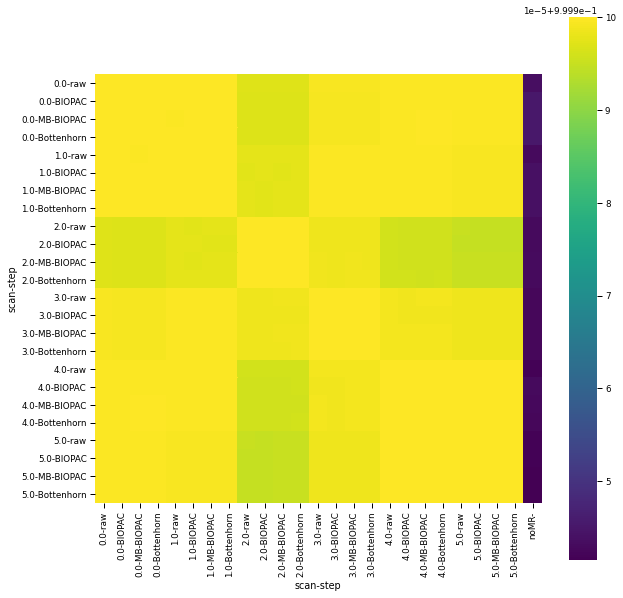

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(dist, square=True, vmin=np.min(dist.values), cmap='viridis', )
fig.savefig(os.path.join('../figures/fft_correlations-{0}.png'.format(basename)), dpi=300)

In [14]:
dist.sort_values('noMR', axis=0, ascending=False)

scan                  0.0                                      1.0            \
step                  raw    BIOPAC MB-BIOPAC Bottenhorn       raw    BIOPAC   
scan step                                                                      
0.0  MB-BIOPAC   1.000000  1.000000  1.000000   1.000000  1.000000  1.000000   
     Bottenhorn  1.000000  1.000000  1.000000   1.000000  1.000000  1.000000   
     BIOPAC      1.000000  1.000000  1.000000   1.000000  1.000000  1.000000   
1.0  MB-BIOPAC   1.000000  1.000000  1.000000   1.000000  1.000000  1.000000   
     BIOPAC      1.000000  1.000000  1.000000   1.000000  1.000000  1.000000   
     Bottenhorn  1.000000  1.000000  1.000000   1.000000  1.000000  1.000000   
0.0  raw         1.000000  1.000000  1.000000   1.000000  1.000000  1.000000   
2.0  MB-BIOPAC   0.999997  0.999997  0.999997   0.999997  0.999998  0.999997   
1.0  raw         1.000000  1.000000  1.000000   1.000000  1.000000  1.000000   
2.0  Bottenhorn  0.999997  0.999997  0.999997   0.999997  0.999998  0.999997   
     BIOPAC      0.999997  0.999997  0.999997   0.999997  0.999998  0.999998   
4.0  BIOPAC      1.000000  1.000000  1.000000   1.000000  1.000000  1.000000   
2.0  raw         0.999997  0.999997  0.999997   0.999997  0.999998  0.999997   
4.0  MB-BIOPAC   1.000000  1.000000  1.000000   1.000000  1.000000  1.000000   
3.0  BIOPAC      0.999999  0.999999  0.999999   0.999999  1.000000  1.000000   
4.0  Bottenhorn  1.000000  1.000000  1.000000   1.000000  1.000000  1.000000   
3.0  raw         0.999999  0.999999  0.999999   0.999999  1.000000  1.000000   
     MB-BIOPAC   0.999999  0.999999  0.999999   0.999999  1.000000  1.000000   
     Bottenhorn  0.999999  0.999999  0.999999   0.999999  1.000000  1.000000   
5.0  BIOPAC      1.000000  1.000000  1.000000   1.000000  0.999999  0.999999   
4.0  raw         1.000000  1.000000  1.000000   1.000000  1.000000  1.000000   
5.0  raw         1.000000  1.000000  1.000000   1.000000  0.999999  0.999999   
     MB-BIOPAC   1.000000  1.000000  1.000000   1.000000  0.999999  0.999999   
     Bottenhorn  1.000000  1.000000  1.000000   1.000000  0.999999  0.999999   

scan                                       2.0            ...        3.0  \
step            MB-BIOPAC Bottenhorn       raw    BIOPAC  ... Bottenhorn   
scan step                                                 ...              
0.0  MB-BIOPAC   1.000000   1.000000  0.999997  0.999997  ...   0.999999   
     Bottenhorn  1.000000   1.000000  0.999997  0.999997  ...   0.999999   
     BIOPAC      1.000000   1.000000  0.999997  0.999997  ...   0.999999   
1.0  MB-BIOPAC   1.000000   1.000000  0.999997  0.999997  ...   1.000000   
     BIOPAC      1.000000   1.000000  0.999997  0.999998  ...   1.000000   
     Bottenhorn  1.000000   1.000000  0.999997  0.999997  ...   1.000000   
0.0  raw         1.000000   1.000000  0.999997  0.999997  ...   0.999999   
2.0  MB-BIOPAC   0.999998   0.999998  1.000000  1.000000  ...   0.999999   
1.0  raw         1.000000   1.000000  0.999998  0.999998  ...   1.000000   
2.0  Bottenhorn  0.999998   0.999998  1.000000  1.000000  ...   0.999999   
     BIOPAC      0.999997   0.999997  1.000000  1.000000  ...   0.999999   
4.0  BIOPAC      1.000000   1.000000  0.999996  0.999996  ...   0.999999   
2.0  raw         0.999997   0.999997  1.000000  1.000000  ...   0.999999   
4.0  MB-BIOPAC   1.000000   1.000000  0.999996  0.999996  ...   0.999999   
3.0  BIOPAC      1.000000   1.000000  0.999999  0.999999  ...   1.000000   
4.0  Bottenhorn  1.000000   1.000000  0.999996  0.999996  ...   0.999999   
3.0  raw         1.000000   1.000000  0.999999  0.999999  ...   1.000000   
     MB-BIOPAC   1.000000   1.000000  0.999999  0.999999  ...   1.000000   
     Bottenhorn  1.000000   1.000000  0.999999  0.999999  ...   1.000000   
5.0  BIOPAC      0.999999   0.999999  0.999995  0.999995  ...   0.999999   
4.0  raw         1.000000   1.000000  0.999996  0.999996  ...   0.999999   
5.0  raw       

In [15]:
dist.to_csv(os.path.join('../data/fft_correlations-ECG-{0}.csv'.format(basename)))

## ECG collected during multiband, multi-echo EPI sequences

In [16]:
data_fname = '../data/raw/mbme-raw.csv'
timeseries = pd.read_csv(data_fname, header=0, index_col=0)
basename = data_fname.split('/')[-1][:-4]

slices = 48
tr = 1.5
mb = 3

cutoff = 120

fs = 2000.

nyquist = fs/2
Q = 100

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [17]:
fft_eda_nomri = signal.decimate(np.fft.fft(timeseries[timeseries['Trigger'] != 5]['EDA'][:1000000]), 10)
freq_eda_nomri = signal.decimate(np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['EDA'][:1000000].shape[-1], 
                                                d=0.0005), 10)

limit = np.where(freq_eda_nomri >= 60)[0][0]

In [18]:
scans = timeseries['scan'].unique()
scans = [x for x in scans if not np.isnan(x)]
print(scans)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


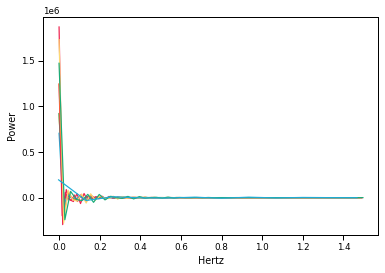

In [19]:
fft_eda = {}
freq = {}
eda = {}
for scan in scans:
    eda[scan] = timeseries[timeseries['scan'] == scan]['EDA']
    fft_eda[scan] = signal.decimate(np.fft.fft(eda[scan]), 10)
    freq[scan] = signal.decimate(np.fft.fftfreq(eda[scan].shape[-1], d=0.0005), 10)
    limit = np.where(freq[scan].real >= 1.5)[0][0]
    g = sns.lineplot(freq[scan][:limit], fft_eda[scan].real[:limit])
    g.set_xlabel('Hertz')
    g.set_ylabel('Power')

In [20]:
index = pd.MultiIndex.from_product([scans, steps_in_denoising], names=['scan', 'step'])

In [21]:
#msc = {}
dist = pd.DataFrame(index=index, columns=index, dtype=float)
for scan1 in scans:
    fft1 = fft_eda[scan1].real
    corr = np.corrcoef(abs(fft1[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
    dist.at[(scan1, 'raw'), 'noMR'] = corr
    
    notch = slices / tr
    filtered = comb_band_stop(notch, eda[scan1], Q, fs)
    fft_bpfilt1 = signal.decimate(np.fft.fft(filtered),10)
    corr = np.corrcoef(abs(fft_bpfilt1[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
    dist.at[(scan1, 'BIOPAC'), 'noMR'] = corr
    
    corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'BIOPAC')] = corr
    dist.at[(scan1, 'BIOPAC'), (scan1, 'raw')] = corr
    
    notch = slices / mb / tr
    filtered = comb_band_stop(notch, eda[scan1], Q, fs)
    fft_bpmbfilt1 = signal.decimate(np.fft.fft(filtered), 10)
    corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
    dist.at[(scan1, 'MB-BIOPAC'), 'noMR'] = corr
    corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'MB-BIOPAC')] = corr
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'raw')] = corr
    corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
    dist.at[(scan1, 'BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'BIOPAC')] = corr
    
    notches = {'slices': slices / mb / tr, 
               'tr': 1 / tr}
    filtered1 = eda[scan1]
    for notch in notches:
        filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)
    
    fft_bottfilt1 = signal.decimate(np.fft.fft(filtered1), 10)
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
    dist.at[(scan1, 'Bottenhorn'), 'noMR'] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
    dist.at[(scan1, 'Bottenhorn'), 'noMR'] = corr
    
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft1[:14000]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'raw')] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
    dist.at[(scan1, 'BIOPAC'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'BIOPAC')] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'MB-BIOPAC')] = corr

    for scan2 in scans:
        fft2 = fft_eda[scan2].real
        corr =  np.corrcoef(abs(fft1[:14000]), abs(fft2[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'raw')] = corr
        dist.at[(scan1, 'raw'), (scan2, 'raw')] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
        dist.at[(scan2, 'raw'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_bottfilt1[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'Bottenhorn')] = corr

        notch = slices / tr
        filtered = comb_band_stop(notch, eda[scan2], Q, fs)
        fft_bpfilt2 = signal.decimate(np.fft.fft(filtered),10)
        corr = np.corrcoef(abs(fft_bpfilt2[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bpfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'Bottenhorn')] = corr
        #corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        #dist.at[(scan2, 'BIOPAC'), (scan1, 'raw')] = corr

        notch = slices / mb / tr
        filtered = comb_band_stop(notch, eda[scan2], Q, fs)
        fft_bpmbfilt2 = signal.decimate(np.fft.fft(filtered), 10)
        corr = np.corrcoef(abs(fft_bpmbfilt2[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_bpmbfilt2[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpmbfilt2[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'Bottenhorn')] = corr
        
        filtered1 = eda[scan2]
        for notch in notches:
            filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)

        fft_bottfilt2 = signal.decimate(np.fft.fft(filtered1),10)
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_eda_nomri[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bottfilt2[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'Bottenhorn')] = corr

        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft2[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpmbfilt2[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan2, 'Bottenhorn')] = corr
        
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan1, 'raw'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan1, 'BIOPAC'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
        dist.at[(scan1, 'MB-BIOPAC'), (scan2, 'Bottenhorn')] = corr

In [22]:
len(fft2)

14827

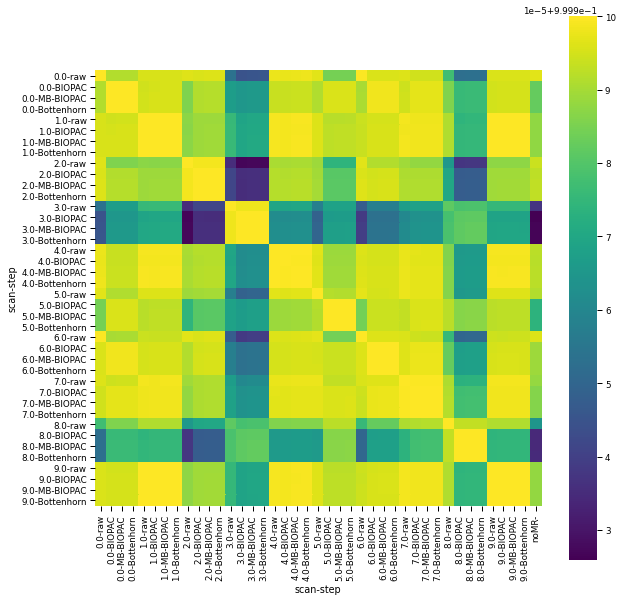

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(dist, square=True, cmap='viridis', vmin=np.min(dist.values))
fig.savefig(os.path.join('../figures/fft_correlations-{0}.png'.format(basename)), dpi=300)

In [24]:
dist.sort_values('noMR', axis=0, ascending=False)

scan                  0.0                                      1.0            \
step                  raw    BIOPAC MB-BIOPAC Bottenhorn       raw    BIOPAC   
scan step                                                                      
0.0  raw         1.000000  0.999992  0.999992   0.999992  0.999996  0.999995   
6.0  raw         0.999999  0.999990  0.999990   0.999990  0.999994  0.999994   
2.0  raw         0.999996  0.999986  0.999986   0.999986  0.999987  0.999987   
     Bottenhorn  0.999996  0.999992  0.999992   0.999992  0.999989  0.999989   
     MB-BIOPAC   0.999996  0.999992  0.999992   0.999992  0.999989  0.999989   
     BIOPAC      0.999996  0.999991  0.999991   0.999991  0.999989  0.999989   
4.0  Bottenhorn  0.999998  0.999994  0.999994   0.999994  0.999999  0.999999   
     MB-BIOPAC   0.999998  0.999994  0.999994   0.999994  0.999999  0.999999   
     raw         0.999998  0.999994  0.999994   0.999994  0.999999  0.999999   
     BIOPAC      0.999998  0.999994  0.999994   0.999994  0.999999  0.999999   
5.0  raw         0.999997  0.999991  0.999991   0.999991  0.999996  0.999996   
6.0  Bottenhorn  0.999996  0.999998  0.999998   0.999998  0.999995  0.999996   
     MB-BIOPAC   0.999996  0.999998  0.999998   0.999998  0.999995  0.999996   
     BIOPAC      0.999996  0.999998  0.999998   0.999998  0.999995  0.999995   
7.0  raw         0.999996  0.999994  0.999995   0.999995  0.999999  0.999998   
9.0  raw         0.999996  0.999995  0.999995   0.999995  1.000000  1.000000   
     MB-BIOPAC   0.999996  0.999995  0.999995   0.999995  1.000000  1.000000   
     Bottenhorn  0.999996  0.999995  0.999995   0.999995  1.000000  1.000000   
     BIOPAC      0.999996  0.999995  0.999995   0.999995  1.000000  1.000000   
1.0  raw         0.999996  0.999995  0.999995   0.999995  1.000000  1.000000   
     Bottenhorn  0.999996  0.999995  0.999995   0.999995  1.000000  1.000000   
     MB-BIOPAC   0.999996  0.999995  0.999995   0.999995  1.000000  1.000000   
     BIOPAC      0.999995  0.999995  0.999995   0.999995  1.000000  1.000000   
7.0  BIOPAC      0.999995  0.999997  0.999997   0.999997  0.999998  0.999998   
     Bottenhorn  0.999995  0.999997  0.999997   0.999997  0.999998  0.999998   
     MB-BIOPAC   0.999995  0.999997  0.999997   0.999997  0.999998  0.999998   
0.0  Bottenhorn  0.999992  1.000000  1.000000   1.000000  0.999995  0.999995   
     MB-BIOPAC   0.999992  1.000000  1.000000   1.000000  0.999995  0.999995   
     BIOPAC      0.999992  1.000000  1.000000   1.000000  0.999995  0.999995   
5.0  Bottenhorn  0.999985  0.999996  0.999996   0.999996  0.999992  0.999993   
     MB-BIOPAC   0.999984  0.999996  0.999996   0.999996  0.999992  0.999993   
     BIOPAC      0.999984  0.999996  0.999996   0.999996  0.999992  0.999993   
8.0  raw         0.999977  0.999986  0.999986   0.999986  0.999991  0.999991   
3.0  raw         0.999954  0.999967  0.999967   0.999967  0.999976  0.999976   
8.0  Bottenhorn  0.999953  0.999976  0.999976   0.999976  0.999975  0.999975   
     MB-BIOPAC   0.999953  0.999976  0.999976   0.999976  0.999975  0.999975   
     BIOPAC      0.999953  0.999976  0.999976   0.999976  0.999974  0.999975   
3.0  Bottenhorn  0.999946  0.999966  0.999966   0.999966  0.999970  0.999970   
     MB-BIOPAC   0.999946  0.999966  0.999966   0.999966  0.999970  0.999970   
     BIOPAC      0.999945  0.999965  0.999965   0.999965  0.999969  0.999970   

scan                                       2.0            ...        7.0  \
step            MB-BIOPAC Bottenhorn       raw    BIOPAC  ... Bottenhorn   
scan step                                                 ...              
0.0  raw         0.999996   0.999996  0.999996  0.999996  ...   0.999995   
6.0  raw         0.999994   0.999994  0.999997  0.999996  ...   0.999994   
2.0  raw         0.999987   0.999987  1.000000  0.999999  ...   0.999988   
     Bottenhorn  0.999989   0.999989  0.999999  1.000000  ...   0.999991   
     MB-BIOPAC   0.999989  

In [25]:
dist.to_csv(os.path.join('../data/fft_correlations-ECG-{0}.csv'.format(basename)))